In [164]:
import numpy as np
import torch
from torch.nn.functional import softmax
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import torchvision
import os
import importlib
import utils
import time
import matplotlib.pyplot as plt
import models
data_dir ="./data"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [113]:
importlib.reload(utils)
importlib.reload(models)

<module 'models' from 'C:\\Users\\ged11\\Dropbox\\0 TUM\\Deep Learning Seminar\\HousesAndBoats\\models.py'>

In [32]:
training_data, validation_data = utils.get_train_val_data(data_dir=data_dir,verbose=True)
testing_data = utils.get_test_data(data_dir=data_dir,verbose=True)
classes = training_data.classes

4 Classes: ['boat', 'house', 'rectangle', 'triangle']
Training Size: 1000
Validation Size: 200
4 Classes: ['boat', 'house', 'rectangle', 'triangle']
Testing Size: 200


In [88]:
training_loader = utils.get_loader(training_data)
validation_loader = utils.get_loader(validation_data)
testing_loader = utils.get_loader(testing_data)

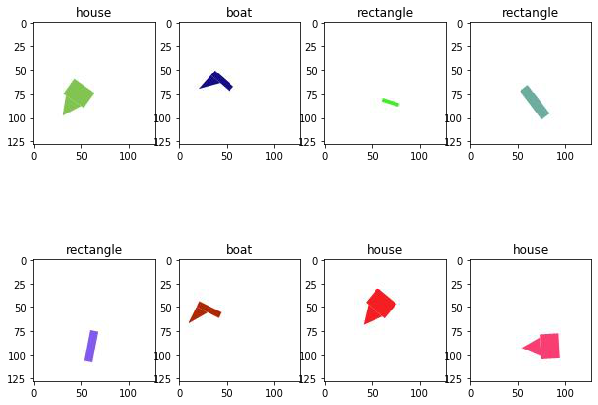

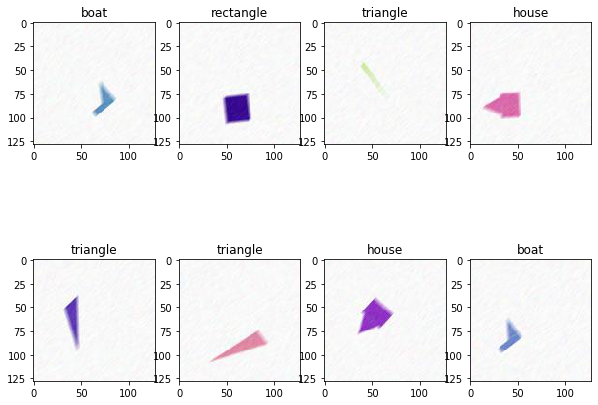

In [89]:
utils.show_images(training_loader,classes,num_imgs=8)
utils.show_images(testing_loader,classes)

In [154]:
model = models.Baseline_CNN_Model()
model.to(device)

Baseline_CNN_Model(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifer): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [143]:
samples, targets = next(iter(training_loader))
samples, targets = samples.to(device), targets.to(device)
score = model(samples)

In [155]:
loss_fn = CrossEntropyLoss()

In [145]:
loss_fn(score,targets)

tensor(1.3875, grad_fn=<NllLossBackward>)

In [197]:
model = models.Baseline_CNN_Model()
model.to(device)
log_every_batches = 30
log_every_epochs = 1
num_epochs = 1
train_losses = []
train_accuracies = []
val_accuracies = []
train_size = len(training_data)
val_size = len(validation_data)
val_losses = []
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=3e-4)
number_of_train_batches = len(training_loader)
for epoch in range(num_epochs):
    batch_losses = []
    num_correct = 0
    model.train()
    for i, data in enumerate(training_loader,0):
        samples, targets = data
        samples, targets = samples.to(device), targets.to(device)
        optimizer.zero_grad()
        scores = model.forward(samples)
        loss = loss_fn(scores, targets)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        y = softmax(scores)
        y = torch.argmax(y,dim=1)
        num_correct += np.sum(y.numpy()==targets.numpy())
        if (i+1) % log_every_batches ==0:
            print("Epoch {0:d}, Batch {1:d}/{2:d}\nTraining Loss {3:.4f}".format(
                epoch+1,i+1,number_of_train_batches,loss.item()))
    epoch_loss = np.mean(batch_losses)
    train_losses.append(epoch_loss)
    epoch_accuracy = num_correct/train_size
    train_accuracies.append(epoch_accuracy)
    if epoch % log_every_epochs ==0:
        print("Epoch {0:d}; Training Loss {1:.4f}; Training Accuracy {2:.4f}".format(epoch+1,
                                                                                     epoch_loss,
                                                                                     epoch_accuracy))
    
    model.eval()
    for i, data in enumerate(validation_loader,0):
        batch_losses = []
        samples, targets = data
        samples, targets = samples.to(device), targets.to(device)
        scores = model(samples)
        loss = loss_fn(scores, targets)
        batch_losses.append(loss.item())
        y = softmax(scores)
        y = torch.argmax(y,dim=1)
        num_correct += np.sum(y.numpy()==targets.numpy())
    val_loss = np.mean(batch_losses)
    val_losses.append(val_loss)
    val_accuracy = np.mean(y.numpy()==targets.numpy())
    val_accuracies.append(val_accuracy)
    if epoch % log_every_epochs ==0:
        print("Epoch {0:d}; Validation Loss {1:.4f}; Validation Accuracy {2:.4f}".format(epoch+1,
                                                                                         val_loss,
                                                                                         val_accuracy))
            
            

C:\Users\ged11\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ged11\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1, Batch 30/63
Training Loss 1.3977
Epoch 1, Batch 60/63
Training Loss 1.3834
Epoch 1; Training Loss 1.3965; Training Accuracy 0.2410
Epoch 1; Validation Loss 1.4870; Validation Accuracy 0.0000


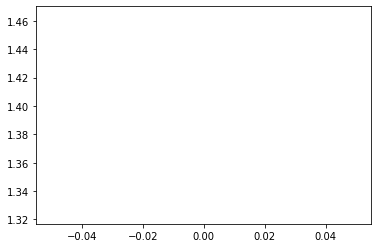

In [193]:
plt.plot(np.arange(len(train_losses)),train_losses)
plt.show()


In [189]:
val_loss

0.7946680784225464